In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('tf')
from keras_applications import imagenet_utils as utils
from keras_applications import correct_pad
from keras.layers import Lambda

import PIL.Image

import innvestigate
import innvestigate.utils
from vis.utils import utils as vis_utils
from keras.preprocessing.image import load_img, img_to_array
#}

Using TensorFlow backend.


In [2]:
global start_index, end_index
start_index = end_index = 0

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [4]:
backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils
keras.backend.image_data_format()

'channels_last'

In [5]:
"""MobileNet v2 models for Keras.

MobileNetV2 is a general architecture and can be used for multiple use cases.
Depending on the use case, it can use different input layer size and
different width factors. This allows different width models to reduce
the number of multiply-adds and thereby
reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet,
except that it uses inverted residual blocks with
bottlenecking features. It has a drastically lower
parameter count than the original MobileNet.
MobileNets support any input size greater
than 32 x 32, with larger image sizes
offering better performance.

The number of parameters and number of multiply-adds
can be modified by using the `alpha` parameter,
which increases/decreases the number of filters in each layer.
By altering the image size and `alpha` parameter,
all 22 models from the paper can be built, with ImageNet weights provided.

The paper demonstrates the performance of MobileNets using `alpha` values of
1.0 (also called 100 % MobileNet), 0.35, 0.5, 0.75, 1.0, 1.3, and 1.4

For each of these `alpha` values, weights for 5 different input image sizes
are provided (224, 192, 160, 128, and 96).


The following table describes the performance of
MobileNet on various input sizes:
------------------------------------------------------------------------
MACs stands for Multiply Adds

 Classification Checkpoint| MACs (M) | Parameters (M)| Top 1 Accuracy| Top 5 Accuracy
--------------------------|------------|---------------|---------|----|-------------
| [mobilenet_v2_1.4_224]  | 582 | 6.06 |          75.0 | 92.5 |
| [mobilenet_v2_1.3_224]  | 509 | 5.34 |          74.4 | 92.1 |
| [mobilenet_v2_1.0_224]  | 300 | 3.47 |          71.8 | 91.0 |
| [mobilenet_v2_1.0_192]  | 221 | 3.47 |          70.7 | 90.1 |
| [mobilenet_v2_1.0_160]  | 154 | 3.47 |          68.8 | 89.0 |
| [mobilenet_v2_1.0_128]  | 99  | 3.47 |          65.3 | 86.9 |
| [mobilenet_v2_1.0_96]   | 56  | 3.47 |          60.3 | 83.2 |
| [mobilenet_v2_0.75_224] | 209 | 2.61 |          69.8 | 89.6 |
| [mobilenet_v2_0.75_192] | 153 | 2.61 |          68.7 | 88.9 |
| [mobilenet_v2_0.75_160] | 107 | 2.61 |          66.4 | 87.3 |
| [mobilenet_v2_0.75_128] | 69  | 2.61 |          63.2 | 85.3 |
| [mobilenet_v2_0.75_96]  | 39  | 2.61 |          58.8 | 81.6 |
| [mobilenet_v2_0.5_224]  | 97  | 1.95 |          65.4 | 86.4 |
| [mobilenet_v2_0.5_192]  | 71  | 1.95 |          63.9 | 85.4 |
| [mobilenet_v2_0.5_160]  | 50  | 1.95 |          61.0 | 83.2 |
| [mobilenet_v2_0.5_128]  | 32  | 1.95 |          57.7 | 80.8 |
| [mobilenet_v2_0.5_96]   | 18  | 1.95 |          51.2 | 75.8 |
| [mobilenet_v2_0.35_224] | 59  | 1.66 |          60.3 | 82.9 |
| [mobilenet_v2_0.35_192] | 43  | 1.66 |          58.2 | 81.2 |
| [mobilenet_v2_0.35_160] | 30  | 1.66 |          55.7 | 79.1 |
| [mobilenet_v2_0.35_128] | 20  | 1.66 |          50.8 | 75.0 |
| [mobilenet_v2_0.35_96]  | 11  | 1.66 |          45.5 | 70.4 |

The weights for all 16 models are obtained and
translated from the Tensorflow checkpoints
from TensorFlow checkpoints found [here]
(https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md).

# Reference

This file contains building code for MobileNetV2, based on
[MobileNetV2: Inverted Residuals and Linear Bottlenecks]
(https://arxiv.org/abs/1801.04381) (CVPR 2018)

Tests comparing this model to the existing Tensorflow model can be
found at [mobilenet_v2_keras]
(https://github.com/JonathanCMitchell/mobilenet_v2_keras)
"""
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import warnings
import numpy as np

# TODO Change path to v1.1
BASE_WEIGHT_PATH = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/'
                    'releases/download/v1.1/')

backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    return utils.preprocess_input(x, mode='tf', **kwargs)


# This function is taken from the original tf repo.
# It ensures that all layers have a channel number that is divisible by 8
# It can be seen here:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                lambda_mask = None,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.

    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils, debug
    debug = False
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if backend.image_data_format == 'channels_first':
                if backend.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if backend.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not backend.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and backend.is_keras_tensor(input_tensor):
            if backend.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = utils._obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    global start_index, end_index
    start_index = end_index = 0
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16, lambda_mask=lambda_mask)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2]* last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1], x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2] * last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1_bn',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1],x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, lambda_mask = None):
    global debug
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)
    #print(prefix, inputs.shape,inputs.shape[0],inputs.shape[1] , in_channels, pointwise_conv_filters, pointwise_filters, filters)
    global start_index, end_index
    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
  
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand_BN',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3), name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False,padding='same' if stride == 1 else 'valid', name=prefix + 'depthwise')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,epsilon=1e-3,momentum=0.999, name=prefix + 'depthwise_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [6]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [7]:
#Function to predict the top 5 accuracy
def top5accuracy_sub(true, predicted):
    assert len(true) == len(predicted)
    result = []
    sublist = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                sublist.append(temp)
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), sublist, error

In [8]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [9]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [10]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [11]:
model_name = 'MobileNetV2'
'''
model = MobileNetV2( input_shape=None,
    alpha=0.35,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
'''

'\nmodel = MobileNetV2( input_shape=None,\n    alpha=0.35,\n    include_top=True,\n    weights="imagenet",\n    input_tensor=None,\n    pooling=None,\n    classes=1000,\n    classifier_activation="softmax")\n'

In [12]:
import gc
K.image_data_format()
keras.backend.clear_session()
gc.collect()
#del model

154

In [66]:
#%%time
#Testing on validation data{
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']

result_validate = {}
fold = 1
k = 4

for i in range(k):
  
    print('Perfoming Fold: ', fold)
    clf_result = {}

    if os.path.exists('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=57255, random_state=42).fit(X) #100x reduction
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans

    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    j = 256
    clf_result[j] = {}

    # clf = KMeans(n_clusters=j)    
    clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
    y_pred = clf.fit_predict(X_new)
    #print clf.cluster_centers_

    for label in set(y_pred):
        print('Cluster: ',j,'Label: ', label)

        #Lesioning and measuring performance
        pred = y_pred.copy()
        loc = np.where(pred==label)
        loc_temp = kmeans.predict(X_new[loc[0]])
        loc_new =[]
        for entry in set(loc_temp):
            temp = np.where(pred_kmeans==entry)[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((5725552,)))  
        lambda_mask[loc_new] = 0.
        model = MobileNetV2(include_top=True,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=None,
                            alpha = 0.35,
                            pooling=None,
                            classes=1000,
                            lambda_mask=lambda_mask,

                            classifier_activation="softmax")
        

        #plt.scatter(X[:,0],X[:,1], c=y_pred) 
        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl_mobile/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
            print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error

        keras.backend.clear_session()
        gc.collect()
        del model
        clf_result[j][label] = [dprime, loc_new]

    result_validate[fold] = clf_result
    fold += 1
    
with open('../../data/pkl_mobile/'+str(method)+'_four_fold_results_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump(result_validate, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Perfoming Fold:  1
GMM
Cluster:  256 Label:  0
animate 1 29 39 0.2564102564102564
inanimate 1 30 39 0.23076923076923073
Cluster:  256 Label:  1
animate 1 4 39 0.8974358974358975
inanimate 1 22 39 0.4358974358974359
Cluster:  256 Label:  2
animate 1 31 39 0.20512820512820518
inanimate 1 29 39 0.2564102564102564
Cluster:  256 Label:  3
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  256 Label:  4
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  256 Label:  5
animate 1 28 39 0.28205128205128205
inanimate 1 25 39 0.3589743589743589
Cluster:  256 Label:  6
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  256 Label:  7
animate 1 4 39 0.8974358974358975
inanimate 1 16 39 0.5897435897435898
Cluster:  256 Label:  8
animate 1 29 39 0.2564102564102564
inanimate 1 27 39 0.3076923076923077
Cluster:  256 Label:  9
animate 1 32 39 0.17948717948717952
inanimate 1 32 39 0.17948717948717952
Cluster:  256 Label:  10
animate 1 6 39 0.

In [13]:
model_name = 'MobileNetV2'
folder='pkl_mobile'
method = 'GMM'
with open('../../data/'+folder+'/'+str(method)+'_four_fold_results_'+model_name+'.pkl', 'rb') as handle:
    result_validate = pickle.load(handle)


In [14]:
result_validate[1].keys()

dict_keys([256])

In [15]:
from functools import reduce
import itertools
fold = 1
loc_ana = {}
loc_ina = {}
pi_ana = {}
pi_ina = {}
loc_ana_avg = []
loc_ina_avg = []
clust = 256
for i in range(4):
    pi_scores = [i[0] for i in result_validate[fold][clust].values()]
    #ana = int(list(pi_scores).index(max(pi_scores)))
    #ina = int(list(pi_scores).index(min(pi_scores)))
    ana = sorted(range(len(pi_scores)), key=lambda i: pi_scores[i],reverse=True)[0:12] #12
    ina = sorted(range(len(pi_scores)), key=lambda i: pi_scores[i])[0:13] #13
    ana_mppi_score = [result_validate[fold][clust][i][0] for i in ana]
    ina_mppi_score = [result_validate[fold][clust][i][0] for i in ina]
    pi_ana[fold] = [result_validate[fold][clust][i][0] for i in ana]
    pi_ina[fold] = [result_validate[fold][clust][i][0] for i in ina]
    #print(fold, ana, ana_mppi_score)
    #print('####',fold, ina, ina_mppi_score)
    #print(fold, ina, [result_validate[fold][256][i][1] for i in ina])
    loc_ana[fold] =  list(itertools.chain.from_iterable([result_validate[fold][clust][i][1] for i in ana]))
    loc_ina[fold] = list(itertools.chain.from_iterable([result_validate[fold][clust][i][1] for i in ina]))
    fold+=1
loc_ana_avg = list(reduce(set.intersection, [set(item) for item in loc_ana.values()]))
loc_ina_avg = list(reduce(set.intersection, [set(item) for item in loc_ina.values()]))
len(loc_ana_avg),len(loc_ina_avg)

(17637, 22671)

In [17]:
pi_scores

[0.0,
 0.3157894736842104,
 -0.39473684210526305,
 -0.10526315789473684,
 -0.07894736842105265,
 -0.10526315789473684,
 -0.10526315789473684,
 0.3421052631578948,
 -0.07894736842105265,
 0.0,
 -0.3421052631578948,
 0.0,
 0.18421052631578938,
 0.026315789473684292,
 0.02631578947368418,
 -0.13157894736842102,
 0.07894736842105265,
 0.0,
 0.0,
 -0.07894736842105265,
 -0.07894736842105265,
 0.10526315789473684,
 -0.05263157894736836,
 -0.21052631578947367,
 0.0,
 -0.05263157894736836,
 -0.10526315789473684,
 -0.10526315789473684,
 -0.02631578947368418,
 -0.02631578947368418,
 0.0,
 0.5526315789473685,
 0.0,
 -0.1578947368421053,
 -0.052631578947368474,
 -0.10526315789473684,
 -0.07894736842105265,
 -0.10526315789473684,
 -0.10526315789473684,
 -0.02631578947368418,
 0.10526315789473684,
 -0.1842105263157895,
 -0.10526315789473684,
 -0.07894736842105265,
 0.05263157894736836,
 0.0,
 -0.10526315789473684,
 -0.3157894736842105,
 -0.052631578947368474,
 -0.1578947368421052,
 0.315789473684210

In [24]:
#%%time
#Testing on test data{
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl_mobile/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl_mobile/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=57255, #100x
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl_mobile/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#import genieclust
#import hdbscan
#import smm

j = 512  #Set this value from scree plot!
method = 'GMM'
print(j)
#clf = hdbscan.HDBSCAN(min_cluster_size=j, gen_min_span_tree=True)
#clf = DBSCAN(eps=5.443)
#clf = KMeans(n_clusters=j,random_state=143)
#clf= SpectralClustering(n_clusters=j,random_state=143)
#clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
#clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
#clf= genieclust.genie.Genie(n_clusters=j)
#clf= smm.SMM(n_components=j, covariance_type='full', random_state=143, tol=1e-12,min_covar=1e-6, n_iter=1000, n_init=1, params='wmcd', init_params='wmcd')
temp = clf.fit(X_new)


y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    print('Cluster: ',j,'Label: ', label, 'Size of Cluster: ',len(loc_new))
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl_mobile/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = dprime


512
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [25]:
with open('../../data/pkl_mobile/'+str(method)+'_512_test_results_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
list(result.values()),X.shape

([0.6666666666666666,
  -0.05128205128205132,
  0.02564102564102566,
  -0.07692307692307698,
  -0.07692307692307698,
  0.3076923076923077,
  -0.07692307692307687,
  0.0,
  0.02564102564102566,
  0.10256410256410253,
  -0.05128205128205132,
  0.1794871794871794,
  0.0,
  0.1282051282051282,
  -0.02564102564102566,
  -0.05128205128205132,
  0.4871794871794872,
  0.0,
  0.1282051282051282,
  0.0,
  -0.02564102564102566,
  0.0,
  0.23076923076923084,
  -0.02564102564102566,
  -0.02564102564102566,
  -0.05128205128205132,
  -0.02564102564102566,
  -0.05128205128205132,
  0.0,
  0.0,
  -0.05128205128205132,
  0.02564102564102566,
  -0.05128205128205132,
  0.15384615384615385,
  -0.05128205128205132,
  -0.05128205128205132,
  0.07692307692307687,
  0.20512820512820507,
  0.02564102564102566,
  -0.07692307692307698,
  -0.02564102564102566,
  0.05128205128205132,
  -0.1282051282051282,
  -0.02564102564102566,
  -0.05128205128205132,
  0.07692307692307687,
  0.0,
  0.05128205128205132,
  -0.0256

In [27]:
x = X[:,0]
y = X[:,1]

In [28]:
print(X.shape)

(5725552, 2)


In [29]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((5725552,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

57255 57255


In [30]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana = int(list(result.values()).index(max(result.values())))
ina = int(list(result.values()).index(min(result.values())))
print(result[ana], -1*(result[ina]))

0 50
0.6666666666666666 0.46153846153846156


In [22]:
%time
from collections import Counter
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
folder ='pkl_mobile'
#classes = ['T5A','T5B']
#folder ='pkl_test_5'

layer_info[label] = {}
#Before lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

#pred = clf.predict(X_new)
#loc = np.where(pred==label)[0]
#loc_new =[]
#for i in range(len(loc)):
#    temp = np.where(pred_kmeans==loc[i])[0]
#    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
print('no', '0')
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    print(Counter(true_valid_wids))
    count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
    print(Counter(sub))
    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('No Lesion: ',dprime)
layer_info[label]['no'] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#Animate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ana_avg] = 0.
print('ana-loc', len(loc_ana_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    print(Counter(true_valid_wids))
    count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
    print(Counter(sub))
    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Animate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#InAnimate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ina_avg] = 0.
print('ina-loc', len(loc_ina_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    print(Counter(true_valid_wids))
    count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
    print(Counter(sub))
    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Inanimate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
no 0
Counter({'n02110185': 15, 'n01944390': 10, 'n01534433': 7, 'n02066245': 7})
Counter({'n02110185': 12, 'n01944390': 10, 'n01534433': 7, 'n02066245': 6})
animate 35 39 0.10256410256410253 0.8974358974358975
Counter({'n04442312': 14, 'n02870880': 9, 'n03271574': 9, 'n03388183': 7})
Counter({'n04442312': 12, 'n03271574': 8, 'n02870880': 7, 'n03388183': 6})
inanimate 33 39 0.15384615384615385 0.8461538461538461
No Lesion:  -0.05128205128205132
ana-loc 17637
Counter({'n02110185': 15, 'n01944390': 10, 'n01534433': 7, 'n02066245': 7})
Counter({'n02110185': 4, 'n01944390': 2, 'n01534433': 1})
animate 7 39 0.8205128205128205 0.17948717948717952
Counter({'n04442312': 14, 'n02870880': 9, 'n03271574': 9, 'n03388183': 7})
Counter({'n04442312': 13, 'n03271574': 9, 'n02870880': 7, 'n03388183': 6})
inanimate 35 39 0.10256410256410253 0.8974358974358975
Animate lesion:  0.717948717948718
ina-loc 22671
Counter({'n02110185': 15, 'n0194439

In [ ]:
%time
layer_info = {}
#Comparing Layer lesions
#classes = ['2A','2B']
folder ='mobile/pkl_mobile_2'
#classes = ['T2A','T2B']
#folder ='pkl_test_2'

label = 256
layer_info[label] = {}
#Before lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

#pred = clf.predict(X_new)
#loc = np.where(pred==label)[0]
#loc_new =[]
#for i in range(len(loc)):
#    temp = np.where(pred_kmeans==loc[i])[0]
#    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
print('no', '0')
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[5]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    print(Counter(true_valid_wids))
    count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
    print(Counter(sub))
    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('No Lesion: ',dprime)
layer_info[label]['no'] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#Animate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ana_avg] = 0.
print('ana-loc', len(loc_ana_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[5]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    print(Counter(true_valid_wids))
    count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
    print(Counter(sub))
    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Animate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#InAnimate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ina_avg] = 0.
print('ina-loc', len(loc_ina_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[5]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    print(Counter(true_valid_wids))
    count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
    print(Counter(sub))
    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Inanimate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

In [162]:
list(set(loc_ana_avg) & set(loc_ina_avg))

[]

In [142]:
from collections import Counter
print(Counter(true_valid_wids))
count, sub,  error  = top5accuracy_sub(true_valid_wids, predicted_valid_wids)
print(Counter(sub))

Counter({'n03481172': 12, 'n04398044': 12, 'n04330267': 8, 'n04404412': 7})
Counter({'n04398044': 8})


(5725552,) (5725552,) (5725552,)


Text(0.5, 1.0, 'Performance Impact - Density plot')

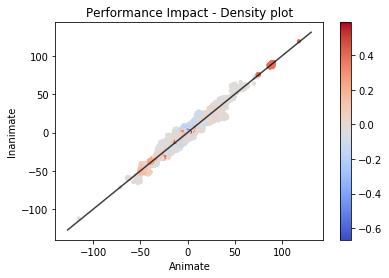

In [17]:
#Density Plot for Animate/Inanimate

print(x.shape,y.shape,z.shape)
fig, ax = plt.subplots()
cs = ax.scatter(x, y, c=z, s=10,cmap='coolwarm')
cbar = fig.colorbar(cs)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('Animate')
plt.ylabel('Inanimate')
plt.title('Performance Impact - Density plot')
#plt.savefig('../../results/'+str(method)+'_results_density.png', format='png',dpi=200)

In [ ]:
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
x = X[:,0]
y = X[:,1]

spax = []
spay = []
spix = []
spiy = []
for i in range(0,len(x)):
    if z[i] in loc_ana_avg:
        spax.append(x[i])
        spay.append(y[i])
    elif z[i] in loc_ina_avg:
        spix.append(x[i])
        spiy.append(y[i])
spax = np.asarray(spax)
spay = np.asarray(spay)
spix = np.asarray(spix)
spiy = np.asarray(spiy)

In [76]:
len(z)

5725552

In [ ]:
#Density Plot for Animate/Inanimate

print(x.shape,y.shape,z.shape)
fig, ax = plt.subplots(figsize=(9,9))
cs = ax.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
#confidence_ellipse(spax, spay, ax, edgecolor='red',n_std=3)
#confidence_ellipse(spix, spiy, ax, edgecolor='blue',n_std=3)
#plt.tricontour(x, y, z,cmap='coolwarm')

m = plt.cm.ScalarMappable(cmap='coolwarm')
m.set_array(x)
m.set_clim(-1., 1.)
#plt.colorbar(m, boundaries=np.linspace(-1.,1., len(x)),orientation='horizontal')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
#ax.scatter(spax,spay,c='#0000ff')
ax.scatter(spix,spiy,c='#ff7f0e')
ax.plot(lims, lims, 'k--', alpha=0.75)
#plt.xlim([0,40])
#plt.ylim([0,40])
#plt.xlabel('Animate')
#plt.ylabel('Inanimate')
#plt.title('Performance Impact - Scatter plot - MobilenetV2')
fig.tight_layout()
#plt.savefig('../../results/'+str(method)+'_results_density_inanimate.png', format='png',dpi=500)

In [ ]:
#Density Plot for Animate/Inanimate

for f in range(1,5,1):
    spax = []
    spay = []
    spix = []
    spiy = []
    for i in range(0,len(z)):
        if z[i] == result[ana]:
            spax.append(x[i])
            spay.append(y[i])
        elif z[i] == result[ina]:
            spix.append(x[i])
            spiy.append(y[i])
    spax = np.asarray(spax)
    spay = np.asarray(spay)
    spix = np.asarray(spix)
    spiy = np.asarray(spiy)

    print(x.shape,y.shape,z.shape)
    fig, ax = plt.subplots(figsize=(9,9))
    cs = ax.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
    #confidence_ellipse(spax, spay, ax, edgecolor='red',n_std=3)
    #confidence_ellipse(spix, spiy, ax, edgecolor='blue',n_std=3)
    #plt.tricontour(x, y, z,cmap='coolwarm')

    m = plt.cm.ScalarMappable(cmap='coolwarm')
    m.set_array(x)
    m.set_clim(-1., 1.)
    #plt.colorbar(m, boundaries=np.linspace(-1.,1., len(x)),orientation='horizontal')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    #ax.scatter(spax,spay,c='#0000ff')
    ax.scatter(spix,spiy,c='#ff7f0e')
    ax.plot(lims, lims, 'k--', alpha=0.75)
    plt.xlim([0,40])
    plt.ylim([0,40])
    #plt.xlabel('Animate')
    #plt.ylabel('Inanimate')
    #plt.title('Performance Impact - Scatter plot - MobilenetV2')
    fig.tight_layout()
    plt.savefig('../../results/'+str(method)+'_results_density_inanimate.png', format='png',dpi=500)

In [238]:
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    

In [ ]:
ana_indices = []
ina_indices = []
for i,v in enumerate(z):
    if v in loc_ana_avg:
        ana_indices.append(i)
    elif v in loc_ina_avg:
        ina_indices.append(i)

In [22]:
total_weights = 0
lcount = 0
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0 and layer.name != 'Logits':
        total_weights += layer.output_shape[1]*layer.output_shape[2]*layer.output_shape[3]
        lcount += 1
        #print(layer.name, layer.output_shape,layer.input_shape, total_weights)
lcount

104

In [ ]:
print(len(loc_ana_avg))

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
X = np.arange(1,105)
Y = [0 for i in range(1,105)]
assert len(X) == len(Y)
lcount = 0
s = e = 0
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0 and layer.name != 'Logits':
        s = e
        e += layer.output_shape[1]*layer.output_shape[2]*layer.output_shape[3]
        for i in range(s,e):
            if i in loc_ana_avg:
                Y[lcount] += 1
        Y[lcount] = Y[lcount] / (e-s)
        lcount += 1

with open('../../data/pkl_mobile/'+str(method)+'_animate_distribution.pkl', 'wb') as handle:
    pickle.dump([X,Y], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#plt.ylim([0,1.])
plt.xlim([1,105])
rect = plt.bar(X,Y)
#plt.ylabel('Proportion of neurons relative to layer size')
#plt.xlabel('MobilenetV2 Layers')
#plt.title('Neurons from the animate cluster')
plt.savefig('../../results/'+str(method)+'_results_ana_hist_alt.png', format='png')

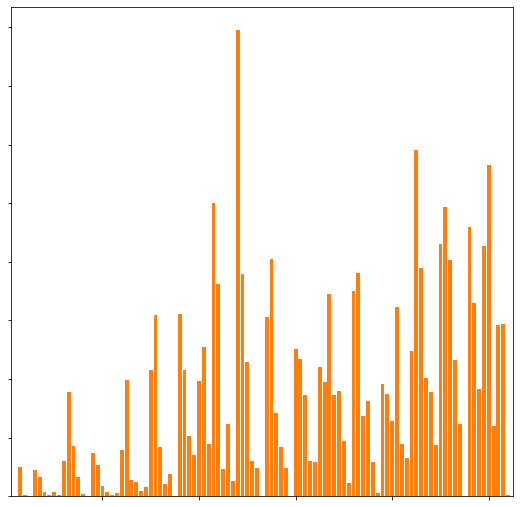

In [241]:
fig = plt.figure(1,figsize=(9,9))
ax = fig.add_subplot(111)
plt.xlim([1,105])
rect = plt.bar(X,Y,color='C1')
ax.set_xticklabels([])
ax.set_yticklabels([])
#plt.ylabel('Proportion of neurons relative to layer size')
plt.savefig('../../results/'+str(method)+'_results_ina_hist_alt.png', format='png')

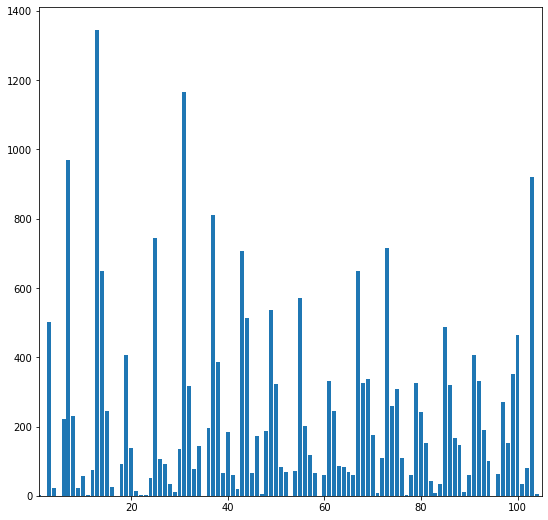

In [247]:
fig, ax = plt.subplots(figsize=(9,9))
X = np.arange(1,105)
Y = [0 for i in range(1,105)]
assert len(X) == len(Y)
lcount = 0
s = e = 0
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0 and layer.name != 'Logits':
        s = e
        e += layer.output_shape[1]*layer.output_shape[2]*layer.output_shape[3]
        for i in range(s,e):
            if i in loc_ina_avg:
                Y[lcount] += 1
        #Y[lcount] = Y[lcount] / (e-s)
        lcount += 1

with open('../../data/pkl_mobile/'+str(method)+'_inanimate_distribution_13_neuron.pkl', 'wb') as handle:
    pickle.dump([X,Y], handle, protocol=pickle.HIGHEST_PROTOCOL)
#plt.ylim([0,1.])
plt.xlim([1,105])
rect = plt.bar(X,Y)
#plt.ylabel('Proportion of neurons relative to layer size')
#plt.xlabel('MobilenetV2 Layers')
#plt.title('Neurons from the inanimate cluster')
plt.savefig('../../results/'+str(method)+'_results_ina_hist_alt.png', format='png')

In [248]:
top10_ina_cluster_n = [Y.index(i)+1 for i in sorted(Y,reverse=True)[0:10]]

In [249]:
top10_ina_cluster_n

[13, 31, 7, 103, 37, 25, 73, 43, 14, 14]

In [27]:
import gc
keras.backend.clear_session()
gc.collect()
del model

In [74]:
print(ana,ina)

[75, 68, 31, 193, 227, 253, 168, 132, 124, 208, 7, 172, 159, 254, 50] [169, 243, 230, 111, 2, 10, 121, 87, 223, 47, 103, 184, 236]


In [ ]:
#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)

In [ ]:
#Pre-trained model - With lesion
label=ana
print(label,result[label])
pred = clf.predict(X_new)
loc = np.where(pred==label)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
print(len(loc_new),' out of 5725552')
lambda_mask[loc_new] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

In [ ]:

image_list_valid = '../../data/pkl_mobile/inanimate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
print(count, error)
c=0
w=0
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        c +=1
        print(i,'1 - Correct')
    else:
        w+=1
        print(i,'0 - Wrong')
print(c,w)

In [ ]:
image_name = im_valid_test[5]
_img = load_img(image_name,target_size=(224,224))
plt.imshow(_img)

In [ ]:

layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

In [ ]:
# Get model
# Strip softmax layer
#model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

In [ ]:
# Add batch axis and preprocess
image_name = im_valid_test[5]
x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
print(x.shape)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [ ]:
# Add batch axis and preprocess
image_name = im_valid_test[5]
x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
print(x.shape)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [23]:
no_specific_impact_idx = 4
no_impact_idx = 28
animate_impact_idx = ana
inanimate_impact_idx = ina

-1 animate
-1 inanimate
1 0.5897435897435898
1 animate
1 inanimate
19 -0.6666666666666666
19 animate
19 inanimate
28 -0.02564102564102566
28 animate
28 inanimate
4 0.0
4 animate
4 inanimate


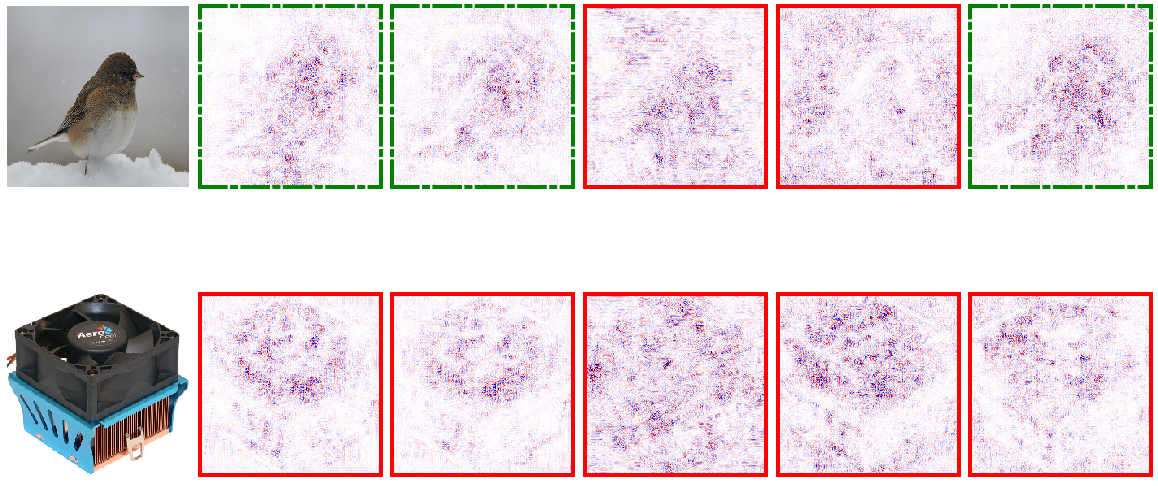

In [32]:
import matplotlib.gridspec as gridspec

#fig = plt.figure(figsize=(8, 24),constrained_layout=True) #figsize - width,height
fig = plt.figure(figsize=(16, 8),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=4/72,h_pad=4/72, hspace=0, wspace=0)
spec = gridspec.GridSpec(ncols=6, nrows=2, figure=fig)
original_flag = 0
row= column = 0
for high_impact_cluster in [-1,animate_impact_idx,inanimate_impact_idx,no_impact_idx,no_specific_impact_idx]:
    if high_impact_cluster == -1:
        column = 1 
        #Pre-trained model - Without lesion
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)
    else:
        #Pre-trained model - With lesion
        row =  0
        if high_impact_cluster == no_impact_idx:
            column = 2
        elif high_impact_cluster == no_specific_impact_idx:
            column = 3
        elif high_impact_cluster == animate_impact_idx:
            column = 4
        else:
            column = 5
        label=high_impact_cluster
        print(label,result[label])
        pred = clf.predict(X_new)
        loc = np.where(pred==label)
        loc_temp = kmeans.predict(X_new[loc[0]])
        loc_new =[]
        for entry in set(loc_temp):
            temp = np.where(pred_kmeans==entry)[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_new] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
        
    layer_idx = vis_utils.find_layer_idx(model, 'Logits')
    model.layers[layer_idx].activation = keras.activations.linear
    
    # Create analyzer
    analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)
    
    for class_label in ['animate','inanimate']:
        image_list_valid = '../../data/pkl_mobile/'+class_label+'_MobileNetV2_image_list_test.txt'
        im_valid_test = []
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))

        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
        print(high_impact_cluster, class_label)
        
        color = []
        line_style = []
        c=0
        w=0
        flag  = 0
        for i in range(len(true_valid_wids)):
            flag  = 0
            temp = true_valid_wids[i]
            for j in predicted_valid_wids[i][0:5]:
                if j == temp:
                    flag = 1
                    break
            if flag == 1:
                c +=1
                color.append('green')
                line_style.append('-.')
                #print(i,'1 - Correct')
            else:
                w+=1
                color.append('red')
                line_style.append('-')
                #print(i,'0 - Wrong')
        #print(c,w)
        
        for image_idx in range(7,8,1): #2,3 - 6,7 - 7,8
            _img = load_img(im_valid_test[image_idx],target_size=(224,224))
            if original_flag < 2:
                ax = fig.add_subplot(spec[row,0])
                ax.imshow(_img)
                ax.axis('off')
                ax.set_aspect('equal')     
                
            x = preprocess_image_batch([im_valid_test[image_idx]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            #print(x.shape)
            # Apply analyzer w.r.t. maximum activated output-neuron
            a = analyzer.analyze(x)

            # Aggregate along color channels and normalize to [-1, 1]
            a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
            a /= np.max(np.abs(a))
            # Plot
            ax = fig.add_subplot(spec[row,column])
            ax.imshow(a[0], cmap="seismic", clim=(-1, 1))
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor(color[image_idx])
                spine.set_linestyle(line_style[image_idx])
                spine.set_linewidth(4.)
            ax.set_aspect('equal')
            row += 1
            if high_impact_cluster == no_impact_idx:
                column = 2
            elif high_impact_cluster == no_specific_impact_idx:
                column = 3
            elif high_impact_cluster == animate_impact_idx:
                column = 4
            elif high_impact_cluster == inanimate_impact_idx:
                column = 5
            else:
                column = 1
           
  
        if original_flag < 2:
            original_flag += 1
        '''
        print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
        print(count, error)
        '''
        
        
    keras.backend.clear_session()
    gc.collect()
    del model
plt.savefig('../../results/row-3.png', format='png')

In [146]:
lr_name = 'Conv1'

In [147]:
#Visualizing intermediate layers
from keras.preprocessing.image import img_to_array, load_img
import random 

#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
            classifier_activation="softmax", classes=1000)
layer_names_list = [layr.name for layr in model.layers]
print ("layer names list: ", layer_names_list)  

layer names list:  ['input_1', 'Conv1_pad', 'Conv1', 'lambda_1', 'bn_Conv1', 'lambda_2', 'Conv1_relu', 'expanded_conv_depthwise', 'lambda_3', 'expanded_conv_depthwise_BN', 'lambda_4', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'lambda_5', 'expanded_conv_project_BN', 'lambda_6', 'block_1_expand', 'lambda_7', 'block_1_expand_BN', 'lambda_8', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'lambda_9', 'block_1_depthwise_BN', 'lambda_10', 'block_1_depthwise_relu', 'block_1_project', 'lambda_11', 'block_1_project_BN', 'lambda_12', 'block_2_expand', 'lambda_13', 'block_2_expand_BN', 'lambda_14', 'block_2_expand_relu', 'block_2_depthwise', 'lambda_15', 'block_2_depthwise_BN', 'lambda_16', 'block_2_depthwise_relu', 'block_2_project', 'lambda_17', 'block_2_project_BN', 'lambda_18', 'block_2_add', 'block_3_expand', 'lambda_19', 'block_3_expand_BN', 'lambda_20', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'lambda_21', 'block_3_depthwise_BN', 'lambda_22', 'b

In [148]:
selected_layers = [lr_name, 'block_16_project_BN']
matched_indices = [i for i, item in enumerate(layer_names_list) if item in selected_layers]
print (matched_indices)

[2, 252]


In [149]:
selected_layers_outputs = []
for lr in range(len(matched_indices)):
    outputs = model.layers[matched_indices[lr]].output 
    #output from selected layers
    selected_layers_outputs.append(outputs)

In [150]:
visual_model = keras.models.Model(inputs = model.input, outputs = selected_layers_outputs)

In [151]:
image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))

im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
im_temp[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


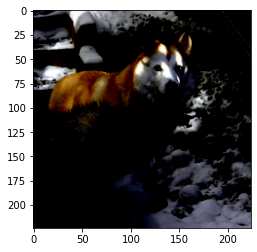

In [152]:
img1 = np.asarray(im_temp[6]).reshape((1, 224, 224, 3))
print(img1.shape)
plt.imshow(im_temp[6])

In [153]:
selected_feature_maps = visual_model.predict(img1)

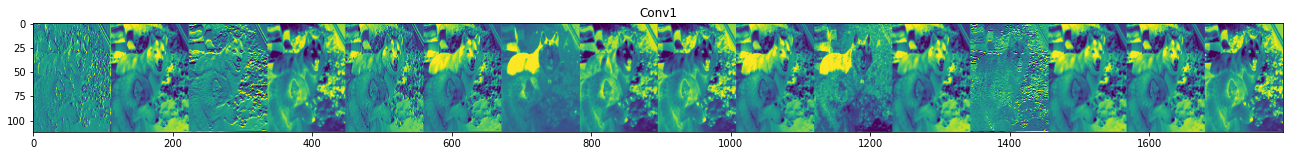

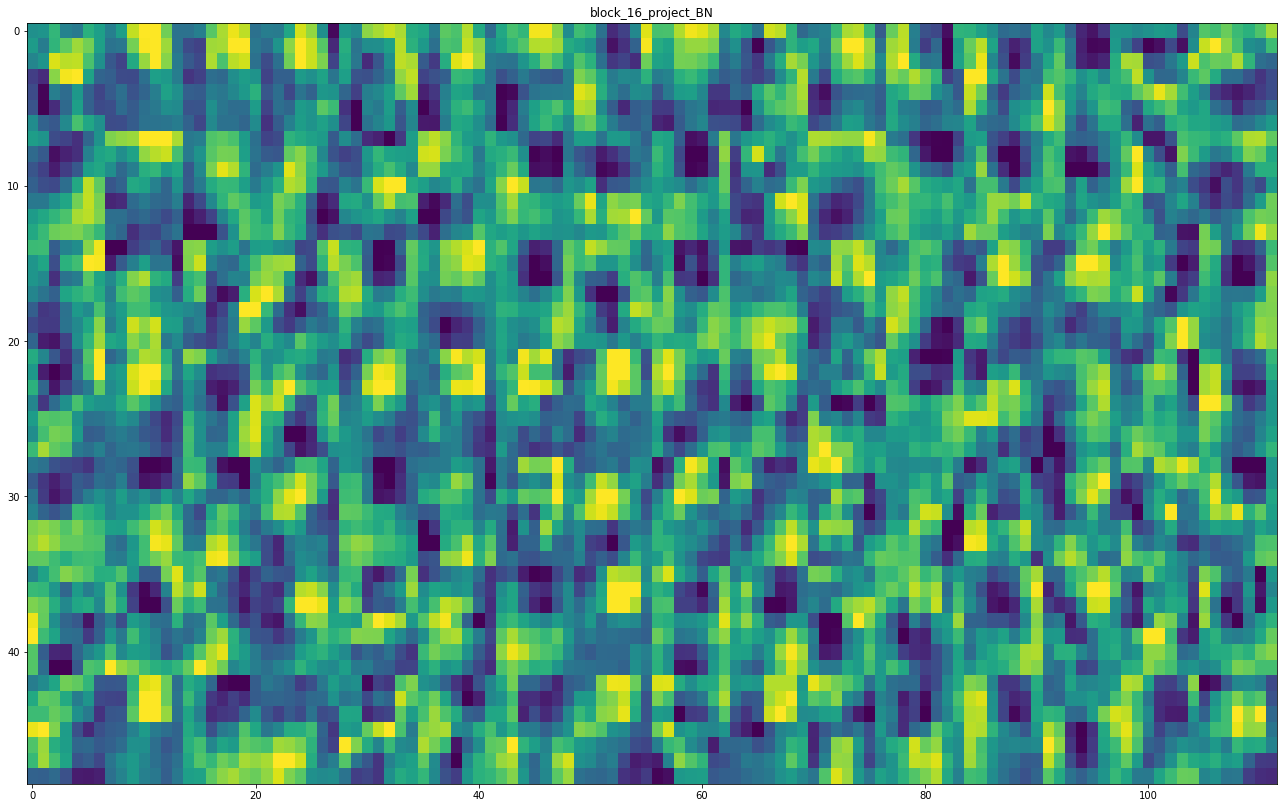

In [154]:
grid1,sl1 = None,None
images_per_row = 16
for lr_name1, feat_map1 in zip(selected_layers, selected_feature_maps):
    n_filters1 = feat_map1.shape[-1]
    n_size1 = feat_map1.shape[1]
    n_cols = n_filters1 // images_per_row
    display_grid1 = np.zeros((n_size1 * n_cols, images_per_row * n_size1))
    for col in range(n_cols):
        for row in range(images_per_row):
            chan_img = feat_map1[0, :, :, col*images_per_row + row]
            chan_img = chan_img - chan_img.mean()
            chan_img = chan_img / chan_img.std()
            chan_img = chan_img * 64
            chan_img = chan_img + 128
            chan_img = np.clip(chan_img, 0, 255).astype('uint8')
            display_grid1[col * n_size1 : (col+1) * n_size1, row * n_size1 : (row+1) * n_size1] = chan_img
    scale1 = 1./n_size1
    if lr_name1 == lr_name:
        grid1, sl1 = display_grid1, scale1
    plt.figure(figsize=(scale1 * display_grid1.shape[1]*1.4, scale1 * display_grid1.shape[0] * 2.))
    plt.title(lr_name1)
    plt.grid(False)
    plt.imshow(display_grid1, aspect='auto', cmap='viridis')


In [115]:
#Visualizing intermediate layers
from keras.preprocessing.image import img_to_array, load_img
import random 

#Pre-trained model - With lesion
lambda_mask = np.ones(shape=((5725552,)))
#print(len(loc_new),' out of 5725552')
lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

In [116]:
selected_layers = [lr_name, 'block_16_project_BN']
matched_indices = [i for i, item in enumerate(layer_names_list) if item in selected_layers]
print (matched_indices)

[252, 254]


In [117]:
selected_layers_outputs = []
for lr in range(len(matched_indices)):
    outputs = model.layers[matched_indices[lr]].output 
    #output from selected layers
    selected_layers_outputs.append(outputs)

In [118]:
visual_model = keras.models.Model(inputs = model.input, outputs = selected_layers_outputs)

In [119]:
image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))

im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
im_temp[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


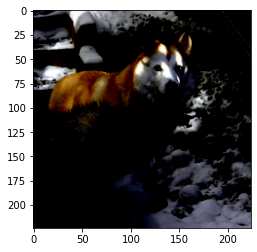

In [120]:
img1 = np.asarray(im_temp[6]).reshape((1, 224, 224, 3))
print(img1.shape)
plt.imshow(im_temp[6])

In [121]:
selected_feature_maps = visual_model.predict(img1)

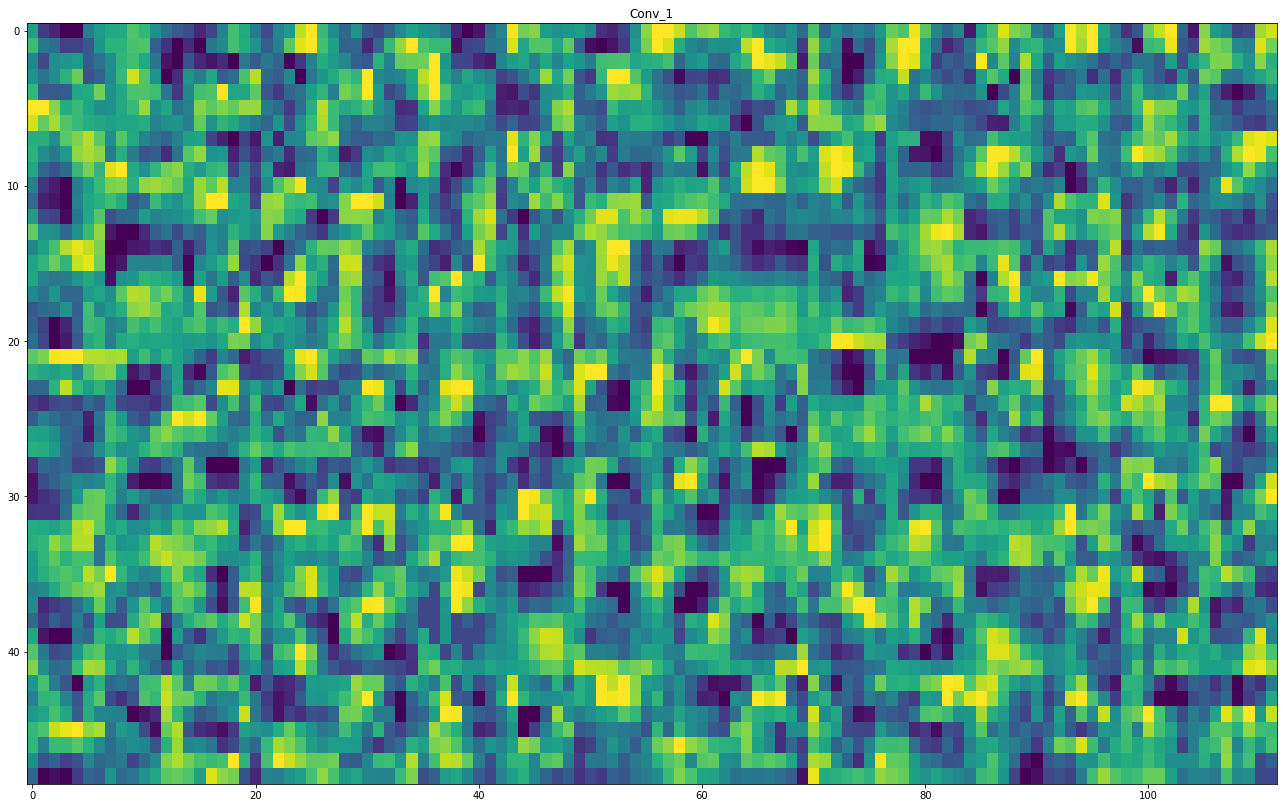

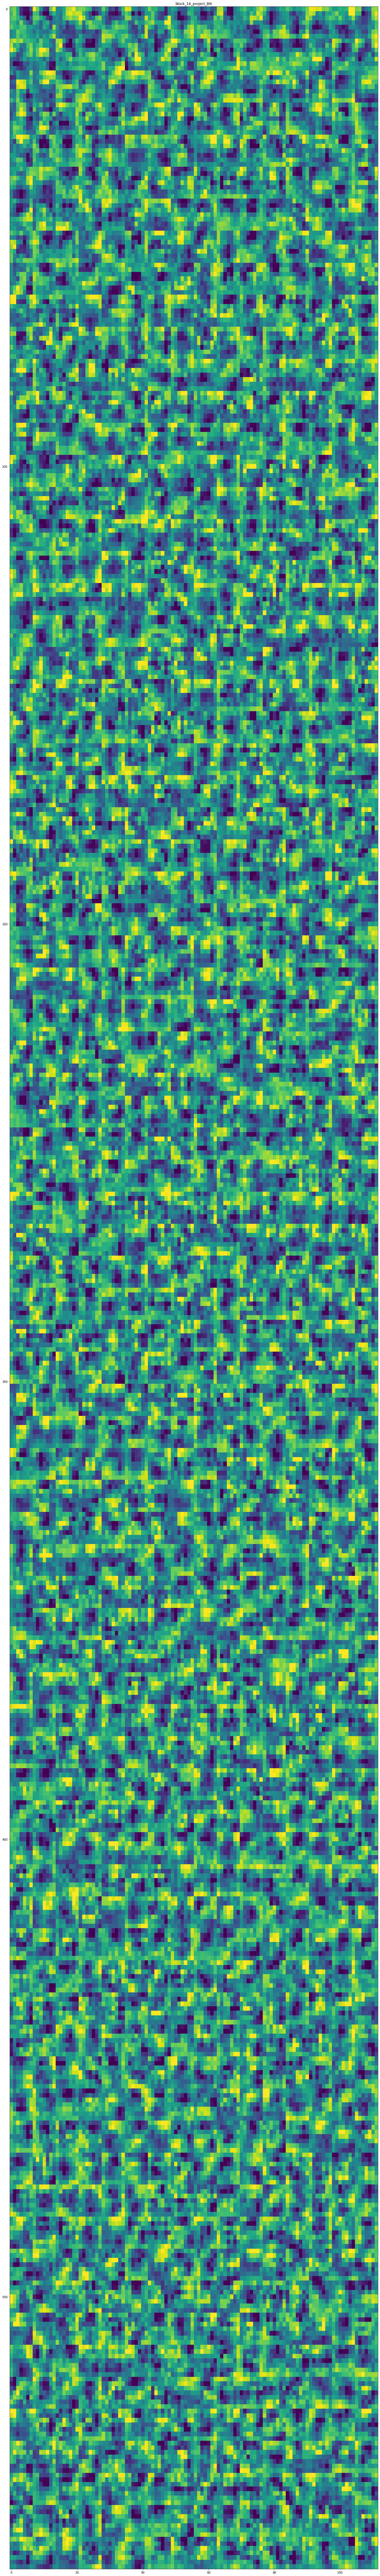

In [122]:
images_per_row = 16
grid2, sl2 = None, None
for lr_name1, feat_map1 in zip(selected_layers, selected_feature_maps):
    n_filters1 = feat_map1.shape[-1]
    n_size1 = feat_map1.shape[1]
    n_cols = n_filters1 // images_per_row
    display_grid1 = np.zeros((n_size1 * n_cols, images_per_row * n_size1))
    for col in range(n_cols):
        for row in range(images_per_row):
            chan_img = feat_map1[0, :, :, col*images_per_row + row]
            chan_img = chan_img - chan_img.mean()
            chan_img = chan_img / chan_img.std()
            chan_img = chan_img * 64
            chan_img = chan_img + 128
            chan_img = np.clip(chan_img, 0, 255).astype('uint8')
            display_grid1[col * n_size1 : (col+1) * n_size1, row * n_size1 : (row+1) * n_size1] = chan_img
    scale1 = 1./n_size1
    if lr_name1 == lr_name:
        grid2,sl2 = display_grid1,scale1
    plt.figure(figsize=(scale1 * display_grid1.shape[1]*1.4, scale1 * display_grid1.shape[0] * 2.))
    plt.title(lr_name1)
    plt.grid(False)
    plt.imshow(display_grid1, aspect='auto', cmap='viridis')


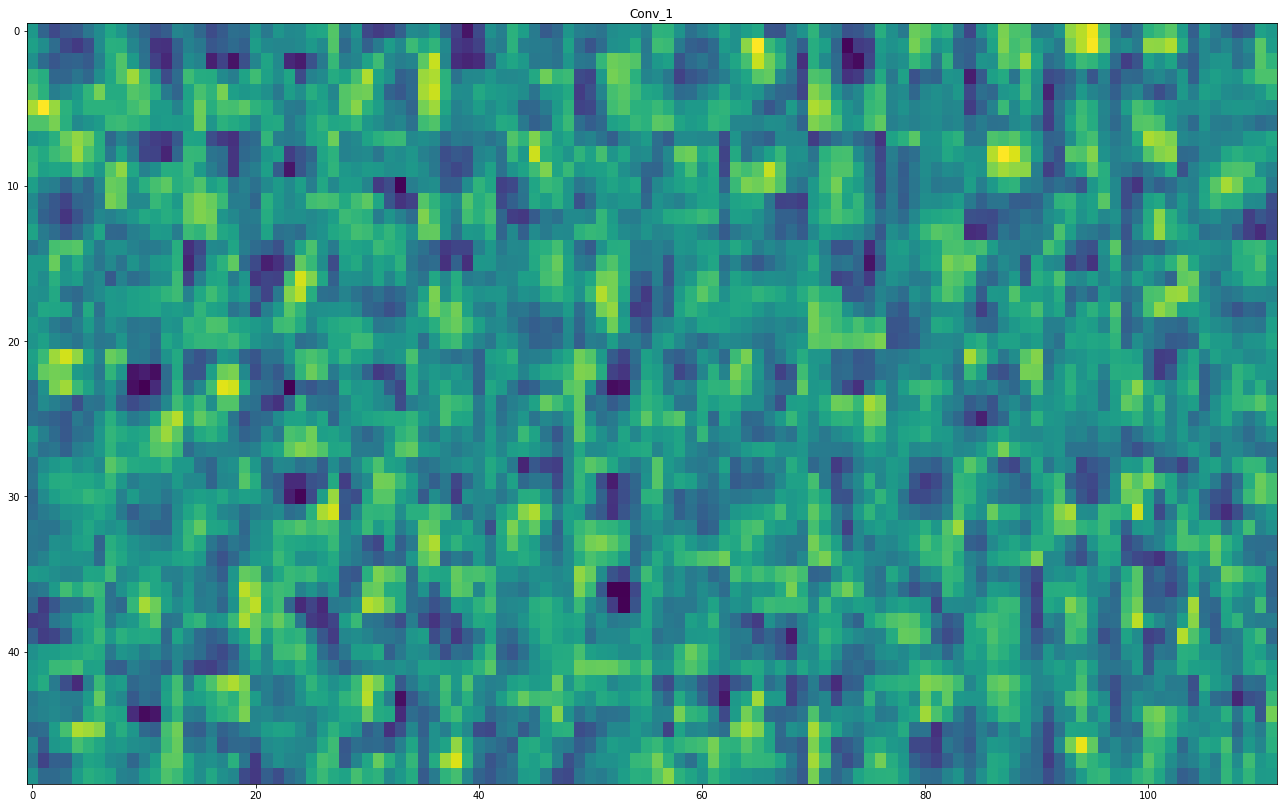

In [131]:
grid = grid2 - grid1
plt.figure(figsize=(scale1 * grid.shape[1]*1.4, scale1 * grid.shape[0] * 2.))
plt.title(lr_name)
plt.grid(False)
plt.imshow(grid, aspect='auto', cmap='viridis')

In [164]:
#Visualizing intermediate layers
from keras.preprocessing.image import img_to_array, load_img
import random 

#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
            classifier_activation="softmax", classes=1000)
layer_names_list = [layr.name for layr in model.layers]
#print ("layer names list: ", layer_names_list)  

In [165]:
selected_layers = [lr_name, 'block_16_project_BN']
matched_indices = [i for i, item in enumerate(layer_names_list) if item in selected_layers]
print (matched_indices)

[2, 252]


In [ ]:
from vis.visualization import visualize_activation, get_num_filters
layer_idx = matched_indices[0]
# Get the number of filters in this layer
num_filters = get_num_filters(model.layers[layer_idx])

In [ ]:
# Draw 6 filters randomly
drawn_filters = random.choices(np.arange(num_filters), k=6)

In [ ]:
# Visualize each filter
for filter_id in drawn_filters:
    img = visualize_activation(model, layer_idx, filter_indices=filter_id, input_modifiers=[Jitter(16)])
    plt.imshow(img)